<a href="https://colab.research.google.com/github/OANInternational/OSM_extractor/blob/main/%5BOSM%5D_Extraccion_de_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Obtención de datos sobre los pueblos de Nikki la de differentes APIs:


*   GeoNames
*   OpenStreetMaps
*   Wikipedia



In [ ]:
!pip install pprint
!pip install pandas
!pip install geopandas
!pip install polylidar
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install geoplot

# --------- GEONAMES ---------
#!pip install geonames;
#!pip install pgeocode;             // Postal code geocoding and distance calculations doesn't support Benin
#!pip install geocoder;       
#!pip install geopy;

# --------- OSM ---------
!pip install OSMPythonTools;

# --------- SPREADSHEET ---------
!pip install --upgrade --quiet gspread;

In [ ]:
import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as col
import numpy as np
import json

import pandas_gbq
import geopandas as gpd
import geoplot as gpt


from polylidar import extractPlanesAndPolygons, extractPolygons, Delaunator
from shapely.geometry import Point, Polygon

# --------- GEONAMES ---------

#import pgeocode
#import geocoder
#from geopy.geocoders import GeoNames

# --------- OSM ---------

from OSMPythonTools.api import Api  
from OSMPythonTools.nominatim import Nominatim # Tool to search OSM data by name and address
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass #read-only API that serves up custom selected parts of the OSM map data

# --------- SPREADSHEET ---------

import gspread
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth

### Asignación de *admin_level*
*   Pais/Pays/Country = 2
*   Departamento/Département/Department = 4
*   Comunas/Commune/County = 6
*   Municipio/Arrondissement/District = 7
*   Pueblo/Village/Village = 8
*   Localidad/Localité/Localite = 9

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
gc = gspread.authorize(GoogleCredentials.get_application_default())

root_path = '/content/drive/Shared drives/Departamento de Tecnología FONSIARA/Proyectos/[P-04] BBDD Pueblos Nikki'

api = Api()
nominatim  = Nominatim()
overpass = Overpass()

#AREA ID
BENIN_ID = 3600192784
BORGOU_ID = 3602803880
NIKKI_COM_ID = 3602859963
NIKKI_ARR_ID = 3611176398
MURCIA_ID = 3606427907 # admin level 6
CASTILLA_ID = 3600349041 # admin level 4

#RELATION ID
BENIN_ID_REL = 192784
BORGOU_ID_REL = 2803880
NIKKI_ID_REL = 2859963

#CONSTANTS
DEG_to_KM2 = 13000
DEG_to_KM = 130

# --------- OSM ---------

def searchInNomi(name):
  res = nominatim.query(name)
  return res.toJSON()

def getAreaInNomi(name):
  res = nominatim.query(name)
  return res.areaId()

def getByIdInOSM(type, id):
  res = api.query(str(type)+'/'+str(id))
  return res.toXML()

def getAreaInOSM(id, type):
  if type == 'way':
      return int(id) + 2400000000
  if type == 'relation':
      return int(id) + 3600000000
  return ''

def getAreaIdOfDataframe(df):
  for index, row in df.iterrows():
    if row['area_id'] == '' or int(row['area_id']) == 0:
      df.at[index,'area_id'] = getAreaInOSM(row['id'], row['type'])

def countBuildingsInAreaID(area_id):
  buildings_query = overpassQueryBuilder(area=area_id, elementType=['way'], selector="building" , out='count')
  buildings_res = overpass.query(buildings_query)
  return buildings_res.countWays()

# --------- AUX ---------

def create_polygons(df):
  df['polygon'] = ""
  for index, row in df.iterrows():
    if (row['boundary_lon'] != '' and  row['boundary_lat'] != ''):
      lon = json.loads(row['boundary_lon'])
      lat = json.loads(row['boundary_lat'])
      df.at[index,'polygon'] = Polygon(zip(lon,lat))

def create_points(df):
  df['point'] = ""
  for index, row in df.iterrows():
    if (row['lat'] != '' and  row['lon'] != ''):
      p = Point(float(row['lon']) , float(row['lat']))
      df.at[index,'point'] = p 

def isIdalready(df, _id):
  for index, row in df.iterrows():
    if int(row['id']) == int(_id):
      return True
  return False


# --------- SPREADSHEET --------- 

def pandasToSheet(sheet_id, worksheet_name, df):
  # Abre el google spreadsheet a partir de su ID
  sh = gc.open_by_key(sheet_id)
  # Abre la hoja de calculo 
  worksheet = sh.worksheet(worksheet_name)
  # Sobreescribe los datos
  writeSheet(df,worksheet)

def sheetToPandas(sheet_id, worksheet_name):
  # Abre el google spreadsheet a partir de su ID
  sh = gc.open_by_key(sheet_id)
  # Abre la hoja de calculo 
  worksheet = sh.worksheet(worksheet_name)
  rows = worksheet.get_all_values()
  # Combierte todos los datos de la hoja en un DataFrame de Pandas
  return pd.DataFrame.from_records(rows[1:],columns=rows[0])

def writeSheet(df, worksheet):
  worksheet.clear()
  worksheet.append_row(df.columns.values.tolist())
  df_list = df.values.tolist()
  for i in range(len(df_list)):
    worksheet.append_row(df_list[i])

# ___DISTRICTS___ 

def saveDistricts(district_df):
  sheet_id = '1pK0QbPW102cR3OBP03gSTZMLdnQdADuO-834GSYJAB0'
  worksheet_name = '[OSM] Municipios'
  district_df = district_df.drop(columns=['polygon'],axis=1)
  pandasToSheet(sheet_id, worksheet_name, district_df)

def loadDistricts():
  sheet_id = '1pK0QbPW102cR3OBP03gSTZMLdnQdADuO-834GSYJAB0'
  worksheet_name = '[OSM] Municipios'
  df = sheetToPandas(sheet_id, worksheet_name)
  create_polygons(df)
  return df

def saveDistrictsBQ(district_df):
  destination_table = 'osm_data.districts'
  district_df = district_df.drop(columns=['polygon'], axis=1)
  pandas_gbq.to_gbq(district_df, project_id='osm-extraccion-de-datos', destination_table=destination_table, if_exists='replace')

def loadDistrictsBQ():
  df = pandas_gbq.read_gbq('SELECT * FROM osm-extraccion-de-datos.osm_data.districts',  project_id='osm-extraccion-de-datos')
  create_polygons(df)
  create_points(df)
  return df

# ___VILLAGES___ 

def saveVillages(village_df):
  sheet_id = '1pK0QbPW102cR3OBP03gSTZMLdnQdADuO-834GSYJAB0'
  worksheet_name = '[OSM] Pueblos'
  village_df = village_df.drop(columns=['polygon','point'],axis=1)
  pandasToSheet(sheet_id, worksheet_name, village_df)

def loadVillages():
  sheet_id = '1pK0QbPW102cR3OBP03gSTZMLdnQdADuO-834GSYJAB0'
  worksheet_name = '[OSM] Pueblos'
  df = sheetToPandas(sheet_id, worksheet_name)
  create_polygons(df)
  create_points(df)
  return df

def saveVillagesBQ(village_df):
  destination_table = 'osm_data.villages'
  village_df = village_df.drop(columns=['polygon', 'point'], axis=1)
  pandas_gbq.to_gbq(village_df, project_id='osm-extraccion-de-datos', destination_table=destination_table, if_exists='replace')

def loadVillagesBQ():
  df = pandas_gbq.read_gbq('SELECT * FROM osm-extraccion-de-datos.osm_data.villages',  project_id='osm-extraccion-de-datos')
  create_polygons(df)
  create_points(df)
  return df

# ___WATER PUMPS___ 

def saveWaterPump(waterpump_df):
  sheet_id = '1Vi2bvcz7SVkWaxHPwcG4dHJcvz8Yxsv9ZWebbJet-8U'
  worksheet_name = '[OSM] Bombas de agua'  
  waterpump_df = waterpump_df.drop(columns=['point'],axis=1)
  pandasToSheet(sheet_id, worksheet_name, waterpump_df)

def loadWaterPump():
  sheet_id = '1Vi2bvcz7SVkWaxHPwcG4dHJcvz8Yxsv9ZWebbJet-8U'
  worksheet_name = '[OSM] Bombas de agua'
  df = sheetToPandas(sheet_id, worksheet_name)
  create_points(df)
  return df

def saveWaterPumpBQ(waterpump_df):
  destination_table = 'osm_data.water_pumps'
  waterpump_df = waterpump_df.drop(columns=['point'], axis=1)
  pandas_gbq.to_gbq(waterpump_df, project_id='osm-extraccion-de-datos', destination_table=destination_table, if_exists='replace')

def loadWaterPumpBQ():
  df = pandas_gbq.read_gbq('SELECT * FROM osm-extraccion-de-datos.osm_data.water_pumps', project_id='osm-extraccion-de-datos')
  create_points(df)
  return df

def saveWaterPumpAguapp(waterpump_df):
  sheet_id = '1Vi2bvcz7SVkWaxHPwcG4dHJcvz8Yxsv9ZWebbJet-8U'
  worksheet_name = '[Aguapp] Bombas de agua'  
  waterpump_df = waterpump_df.drop(columns=['point'],axis=1)
  pandasToSheet(sheet_id, worksheet_name, waterpump_df)

def loadWaterPumpAguapp():
  sheet_id = '1Vi2bvcz7SVkWaxHPwcG4dHJcvz8Yxsv9ZWebbJet-8U'
  worksheet_name = '[Aguapp] Bombas de agua'
  df = sheetToPandas(sheet_id, worksheet_name)
  create_points(df)
  return df

def saveWaterPumpAguappBQ(waterpump_df):
  destination_table = 'osm_data.water_pumps_aguapp'
  waterpump_df = waterpump_df.drop(columns=['point'], axis=1)
  pandas_gbq.to_gbq(waterpump_df, project_id='osm-extraccion-de-datos', destination_table=destination_table, if_exists='replace')

def loadWaterPumpAguappBQ():
  df = pandas_gbq.read_gbq('SELECT * FROM osm-extraccion-de-datos.osm_data.water_pumps_aguapp', project_id='osm-extraccion-de-datos')
  create_polygons(df)
  create_points(df)
  return df


# ___WATER RESERVOIR___ 

def saveWaterReservoir(waterreservoir_df):
  sheet_id = '1Vi2bvcz7SVkWaxHPwcG4dHJcvz8Yxsv9ZWebbJet-8U'
  worksheet_name = '[OSM] Embalses'
  waterreservoir_df = waterreservoir_df.drop(columns=['polygon','point'],axis=1)
  pandasToSheet(sheet_id, worksheet_name, waterreservoir_df)

def loadWaterReservoir():
  sheet_id = '1Vi2bvcz7SVkWaxHPwcG4dHJcvz8Yxsv9ZWebbJet-8U'
  worksheet_name = '[OSM] Embalses'
  df = sheetToPandas(sheet_id, worksheet_name)
  create_polygons(df)
  create_points(df)
  return df

def saveWaterReservoirBQ(waterreservoir_df):
  destination_table = 'osm_data.water_reservoir'
  waterreservoir_df = waterreservoir_df.drop(columns=['polygon','point'], axis=1)
  pandas_gbq.to_gbq(waterreservoir_df, project_id='osm-extraccion-de-datos', destination_table=destination_table, if_exists='replace')

def loadWaterReservoirBQ():
  df = pandas_gbq.read_gbq('SELECT * FROM osm-extraccion-de-datos.osm_data.water_reservoir', project_id='osm-extraccion-de-datos')
  create_polygons(df)
  create_points(df)
  return df

# ___SPAIN WATER RESERVOIR___ 

def saveSpainWaterReservoir(waterreservoir_df):
  sheet_id = '103AlEYjVGasKfpK9Y3Ck2g1PHep3Mw1_7PlbtygXHJA'
  worksheet_name = '[OSM] Embalses'
  waterreservoir_df = waterreservoir_df.drop(columns=['polygon','point'],axis=1)
  pandasToSheet(sheet_id, worksheet_name, waterreservoir_df)

def loadSpainWaterReservoir():
  sheet_id = '103AlEYjVGasKfpK9Y3Ck2g1PHep3Mw1_7PlbtygXHJA'
  worksheet_name = '[OSM] Embalses'
  df = sheetToPandas(sheet_id, worksheet_name)
  create_polygons(df)
  create_points(df)
  return df

def saveSpainWaterReservoirBQ(waterreservoir_df):
  destination_table = 'osm_data.water_reservoir_spain'
  waterreservoir_df = waterreservoir_df.drop(columns=['polygon','point'], axis=1)
  pandas_gbq.to_gbq(waterreservoir_df, project_id='osm-extraccion-de-datos', destination_table=destination_table, if_exists='replace')

def loadSpainWaterReservoirBQ():
  df = pandas_gbq.read_gbq('SELECT * FROM osm-extraccion-de-datos.osm_data.water_reservoir_spain', project_id='osm-extraccion-de-datos')
  create_polygons(df)
  create_points(df)
  return df


def getDistrictOfVillage(district_df, village_df):
  # Loop throught all villages
  for i, village_row in village_df.iterrows():
    # Check if there is already a district
    if village_row['district'] == '':

      # Loop throught all districts to see if the village is inside the polygon
      for j, district_row in district_df.iterrows():
        point = village_row['point']
        isin = district_row['polygon'].contains(point)
        if isin == True :
          village_df.at[i,'district'] = district_row['name']
          break

def getBuildingsInVillage(df):
  for index, village_row in df.iterrows():
    nb_buildings = 0
    density = 0

    # Check if there have already been registered
    if int(village_row['nb_buildings']) < 0:
      nb_buildings = countBuildingsInAreaID(village_row['area_id'])

      # Update the density 
      if nb_buildings > 0:
        density = nb_buildings / (float(str(village_row['area']).replace(',','.')) * 1000000.0)

      df.loc[index, 'nb_buildings'] = nb_buildings
      df.loc[index, 'building_density'] = density
      df.loc[index, 'population_est_building'] = nb_buildings * 5

In [ ]:
# Load all data
district_df = loadDistrictsBQ()
village_df = loadVillagesBQ()
waterpump_df = loadWaterPumpBQ()
#waterpump_aguapp_df = loadWaterPumpAguappBQ()
waterreservoir_df = loadWaterReservoirBQ()
waterreservoirspain_df = loadSpainWaterReservoirBQ()

print('Districts in BQ : ' + str(district_df.shape[0]))
print('Villages in BQ : ' + str(village_df.shape[0]))
print('Water Pumps in BQ : ' + str(waterpump_df.shape[0]))
#print('Water Pumps Aguapp in BQ : ' + str(waterpump_aguapp_df.shape[0]))
print('Water Reservoir in BQ : ' + str(waterreservoir_df.shape[0]))
print('Water Reservoir Spain in BQ : ' + str(loadSpainWaterReservoirBQ.shape[0]))

Downloading: 100%|██████████| 42/42 [00:00<00:00, 268.95rows/s]

Districts in BQ : 7
Villages in BQ : 748
Water Pumps in BQ : 100
Water Reservoir in BQ : 42


### **Districts of Nikki** (County)




In [ ]:
# Get all district in Nikki county

district_query = overpassQueryBuilder(area=NIKKI_COM_ID, elementType=['relation'], selector='"admin_level"="7"', out='body geom')
district_res = overpass.query(district_query,timeout=25)
district_res_json = district_res.toJSON()

district_headers = ['id','area_id','type','name','link','nb_villages','population','density','lat','lon','perim','area','boundary_lat','boundary_lon','polygon']
new_district_data = []

# Save the response data in a dataframe
for ele in district_res_json['elements']:

    # Join all the geometries from the members of the relation
    geo_raw = []
    for memb in ele['members']:
      geo_raw.append(memb['geometry'])
    # Flatten the array of array into one array of objects with lat,lon
    geo_raw = [item for sublist in geo_raw for item in sublist]

    geo_df = pd.DataFrame.from_records(geo_raw)
    poly = Polygon(zip(geo_df['lon'], geo_df['lat']))
    boudary_lat =  str(geo_df['lat'].tolist())
    boudary_lon =  str(geo_df['lon'].tolist())
    ele_row = [
               ele.get('id',0),                   # id 
               0,                                  # area_id 
               ele.get('type',''),                 # type  
               ele['tags'].get('name',''),         # name 
               'https://www.openstreetmap.org/edit?' + str(ele.get('type','')) + '=' + str(ele.get('id','')),    # link
               '',                                 # nb_villages
               '',                                 # population
               '',                                 # density
               str(poly.centroid.y),               # lat
               str(poly.centroid.x),               # lon
               str(poly.length * DEG_to_KM),       # perim
               str(poly.area * DEG_to_KM2),        # area
               boudary_lat,                        # boudary_lat
               boudary_lon,                        # boudary_lon    
               poly,                               # polygon
    ]
    new_district_data.append(ele_row)
    
new_district_df = pd.DataFrame(new_district_data,columns=district_headers)
new_district_df.fillna('',inplace=True)

new_district_df

In [ ]:
# Load districts
district_df = loadDistricts();

In [ ]:
# Update missing values in dataframe from spreadsheet
if new_district_df is not None:
  for index, new_row in new_district_df.iterrows():
    if not (new_row['id'] in district_df['id']):
      district_df = district_df.append(new_row)

# Update missing areas id
getAreaIdOfDataframe(district_df)

In [ ]:
# Save districts
saveDistrictsBQ(district_df)

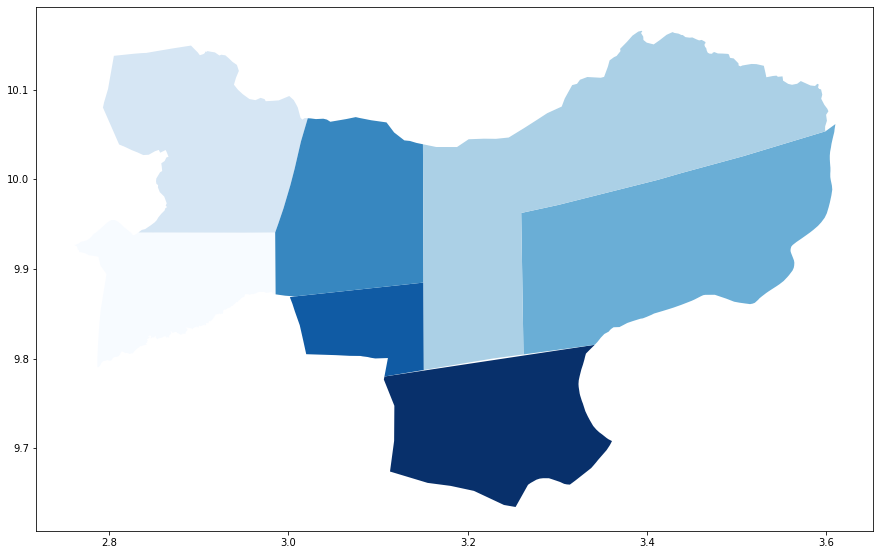

In [ ]:
# Plot the districts 
district_df = loadDistricts();

district_geodf = gpd.GeoDataFrame(district_df, geometry="polygon");
district_geodf.rename(columns={"polygon": "geometry"}, inplace=True);
fig, ax = plt.subplots(1, 1,figsize=(15,15))
district_geodf.plot(column="name",  ax=ax, legend=False, cmap='Blues', figsize=(15,15));

In [ ]:
# Export the figure as a svg
fig.savefig('Arrondissement_Nikki.svg', format='svg', transparent=True )

### **Villages in Nikki** (County)

In [ ]:
village_query = overpassQueryBuilder(area=NIKKI_COM_ID, elementType='way', selector="'place'~'village|locality|town|city|hamlet'", out="body geom")
residential_query = overpassQueryBuilder(area=NIKKI_COM_ID, elementType='way', selector="'landuse'~'residential'", out="body geom")

village_res = overpass.query(village_query)
residential_res = overpass.query(residential_query)

# Transform response into json 
village_json = village_res.toJSON()
residential_res = residential_res.toJSON()

village_headers = ['id','area_id','type','place','district','name','link','lat','lon','perim','area','boundary_lat','boundary_lon','polygon','point','nb_buildings','building_density','population_est_building']
new_village_data = []

# Loop throught the elements in the response
for ele in village_json['elements']:
    geo_df = pd.DataFrame.from_records(ele['geometry'])
    poly = Polygon(zip(geo_df['lon'], geo_df['lat']))
    point = Point(poly.centroid.x,poly.centroid.y)
    boudary_lat =  str(geo_df['lat'].tolist())
    boudary_lon =  str(geo_df['lon'].tolist())
    ele_row = [ 
               ele.get('id',0),                    # id
               0,                                  # area_id
               ele.get('type',''),                 # type
               ele['tags'].get('place',''),        # place
               '',                                 # district
               ele['tags'].get('name',''),         # name
               'https://www.openstreetmap.org/edit?' + str(ele.get('type','')) + '=' + str(ele.get('id','')),  # link
               str(poly.centroid.y),               # lat
               str(poly.centroid.x),               # lon
               str(poly.length * DEG_to_KM),       # perim
               str(poly.area * DEG_to_KM2),        # area
               boudary_lat,                        # boudary_lat
               boudary_lon,                        # boudary_lon
               poly,                               # polygon
               point,                              # point
               -1,                                 # nb_buildings
               0.0,                                # building_density
               0.0,                                # population_est_building
               ]
   
    new_village_data.append(ele_row)

# Loop throught the elements in the response
for ele in residential_res['elements']:
    geo_df = pd.DataFrame.from_records(ele['geometry'])
    poly = Polygon(zip(geo_df['lon'], geo_df['lat']))
    point = Point(poly.centroid.x,poly.centroid.y)
    boudary_lat =  str(geo_df['lat'].tolist())
    boudary_lon =  str(geo_df['lon'].tolist())
    ele_row = [ 
               ele.get('id',0),                    # id
               0,                                  # area_id
               ele.get('type',''),                 # type
               ele['tags'].get('landuse',''),      # landuse
               '',                                 # district
               ele['tags'].get('name',''),         # name
               'https://www.openstreetmap.org/edit?' + str(ele.get('type','')) + '=' + str(ele.get('id','')),  # link
               str(poly.centroid.y),               # lat
               str(poly.centroid.x),               # lon
               str(poly.length * DEG_to_KM),       # perim
               str(poly.area * DEG_to_KM2),        # area
               boudary_lat,                        # boudary_lat
               boudary_lon,                        # boudary_lon
               poly,                               # polygon
               point,                              # point
               -1,                                 # nb_buildings
               0.0,                                # building_density
               0.0,                                # population_est_building
               ]
   
    new_village_data.append(ele_row)

# Create Dataframe from data
new_village_df = pd.DataFrame(new_village_data,columns=village_headers)
print(new_village_df.shape)

[overpass] downloading data: [timeout:25][out:json];area(3602859963)->.searchArea;(way['place'~'village|locality|town|city|hamlet'](area.searchArea);); out body geom;
[overpass] downloading data: [timeout:25][out:json];area(3602859963)->.searchArea;(way['landuse'~'residential'](area.searchArea);); out body geom;


(869, 18)


In [ ]:
# Load villages
village_df = loadVillagesBQ()
village_df.shape

# 268 
# 236 - 1 Nov 2020
# 748 - 1 Ene 2021
# 907 - 18 Feb 2021

Downloading: 100%|██████████| 907/907 [00:00<00:00, 2165.97rows/s]


(907, 20)

In [ ]:
# Update missing values in dataframe from spreadsheet
for index, new_row in new_village_df.iterrows():
  if not isIdalready(village_df,new_row['id']) :
    village_df = village_df.append(new_row)

# Detelet all posible NaN
village_df.fillna('')

# Update missing areas id
getAreaIdOfDataframe(village_df)

# Update missing buildings numbers
# getBuildingsInVillage(village_df)

# Update county origin
getDistrictOfVillage(district_df, village_df)

In [ ]:
village_df.shape

(907, 20)

In [ ]:
getBuildingsInVillage(village_df)

In [ ]:
# Save villages
saveVillagesBQ(village_df)

1it [00:04,  4.35s/it]


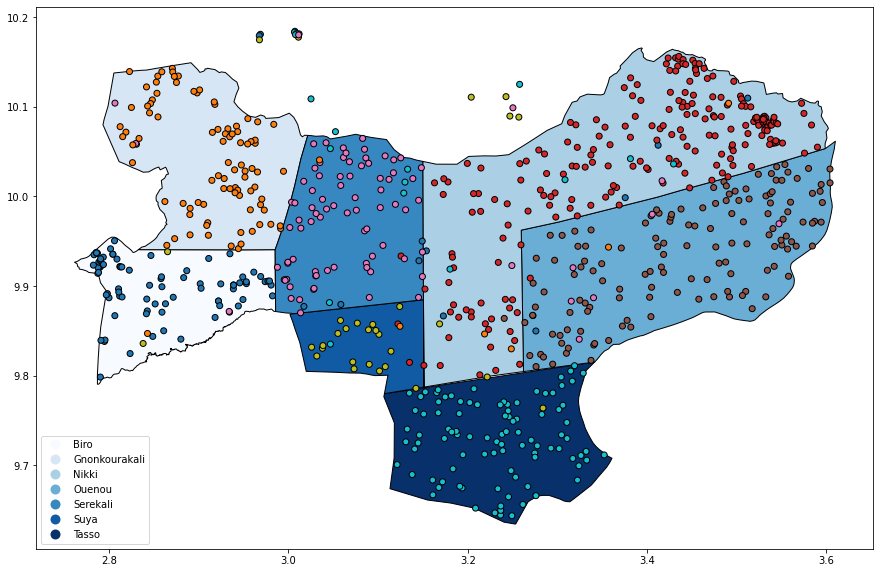

In [ ]:
# Plot the villages 
district_geodf = gpd.GeoDataFrame(district_df, geometry="polygon")
village_way_geodf = gpd.GeoDataFrame(village_df, geometry="polygon")
village_point_geodf = gpd.GeoDataFrame(village_df, geometry="point")

#plt.rcParams["figure.figsize"] = (15,15)
base = district_geodf.plot(column="name", legend=True,figsize=(15,15),cmap='Blues', edgecolor="black");
village_point_geodf.plot(ax = base, column="district",figsize=(15,15),edgecolor="black");

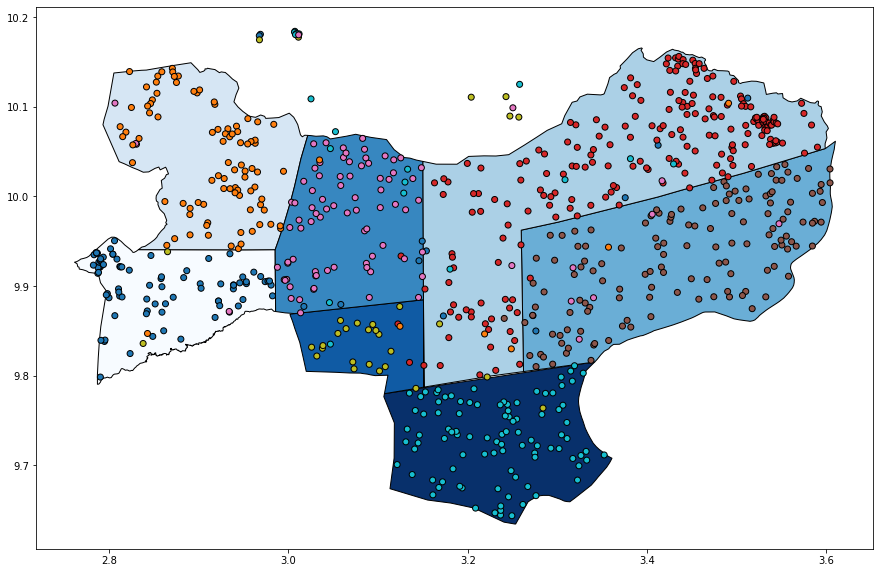

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(15,15))

base = district_geodf.plot(ax=ax, column="name",figsize=(15,15),cmap='Blues', edgecolor="black");
village_point_geodf.plot(ax = base, column="district",figsize=(15,15),edgecolor="black");

# Export the figure as a svg
fig.savefig('Villages_Nikki.svg', format='svg', transparent=True, bbox_inches='tight' )

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)


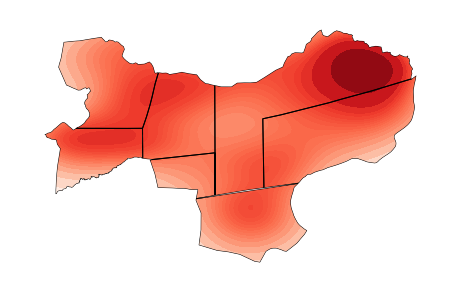

In [ ]:
# Heatmap de los pueblos
ax = gpt.kdeplot(village_point_geodf, clip=district_geodf.geometry, shade=True, cmap='Reds', n_levels=20, shade_lowest=True);
gpt.polyplot(district_geodf, ax=ax, zorder=1);

### **Water Pumps** Nikki

In [ ]:
# Get new data 
pump_query_A = overpassQueryBuilder(area=NIKKI_COM_ID, elementType='node',selector='"man_made"~"water_well|water_tower|water_tap|storage_tank|watermill"')
pump_query_B = overpassQueryBuilder(area=NIKKI_COM_ID, elementType='node',selector='"natural"~"spring"')
pump_query_C = overpassQueryBuilder(area=NIKKI_COM_ID, elementType='node',selector='"amenity"~"drinking_water"')
pump_query_D = overpassQueryBuilder(area=NIKKI_COM_ID, elementType='node',selector='"waterway"~"water_point"')

queries = [pump_query_A,pump_query_B,pump_query_C,pump_query_D]
pump_headers = ['id','tag','lat','lon','link','district']
new_pump_data = []

for query in queries:
  pump_res = overpass.query(query,timeout=25)
  pump_res_json = pump_res.toJSON()


  # loop throught the elements in the response
  for ele in pump_res_json['elements']:
      tag = ele['tags'].get('man_made', ele['tags'].get('natural', ele['tags'].get('amenity', ele['tags'].get('waterway', '' ))))
      ele_row = [
               ele.get('id',''),        # id
               tag,                     # tag
               str(ele.get('lat','')),  # lat
               str(ele.get('lon','')),  # lon
               'https://www.openstreetmap.org/edit?' + str(ele.get('type','')) + '=' + str(ele.get('id','')),    # link
               ''                       # district
               ]
      new_pump_data.append(ele_row)

new_pump_df = pd.DataFrame(new_pump_data,columns=pump_headers)
new_pump_df.shape

[overpass] downloading data: [timeout:25][out:json];area(3602859963)->.searchArea;(node["man_made"~"water_well|water_tower|water_tap|storage_tank|watermill"](area.searchArea);); out body;
[overpass] downloading data: [timeout:25][out:json];area(3602859963)->.searchArea;(node["natural"~"spring"](area.searchArea);); out body;
[overpass] downloading data: [timeout:25][out:json];area(3602859963)->.searchArea;(node["amenity"~"drinking_water"](area.searchArea);); out body;
[overpass] downloading data: [timeout:25][out:json];area(3602859963)->.searchArea;(node["waterway"~"water_point"](area.searchArea);); out body;


(95, 6)

In [ ]:
# Load WaterPumps
pump_df = loadWaterPump()
pump_df.shape

# 88 - 1 Nov 2020
# 100 - 1 Ene 2021

(21, 11)

In [ ]:
# Update missing values in dataframe from spreadsheet
if new_pump_df is not None:
  for index, new_row in new_pump_df.iterrows():
    if not isIdalready(pump_df,new_row['id']) :
      pump_df = pump_df.append(new_row)

# Detelet all posible NaN
pump_df.fillna('')

# Update county origin
# getDistrictOfVillage(district_df, pump_df)

pump_df.shape

(99, 11)

In [ ]:
# Save WaterPumps
saveWaterPumpBQ(pump_df)

1it [00:06,  6.53s/it]


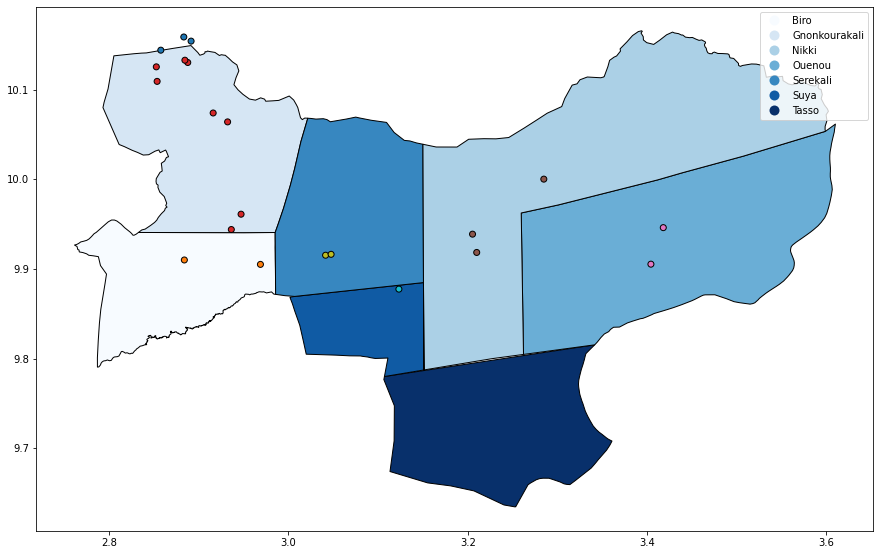

In [ ]:
# Plot the pumps 
district_geodf = gpd.GeoDataFrame(district_df, geometry="polygon")
pumps_geodf = gpd.GeoDataFrame(pump_df, geometry="point")

#plt.rcParams["figure.figsize"] = (15,15)
base = district_geodf.plot(column="name", legend=True,figsize=(15,15),cmap='Blues', edgecolor="black");
pumps_geodf.plot(ax = base, column="district",figsize=(15,15),edgecolor="black");

In [ ]:
# Heatmap de las bombas
ax = gpt.kdeplot(pumps_geodf, clip=district_geodf.geometry, shade=True, cmap='Reds', n_levels=20, shade_lowest=True);
gpt.polyplot(district_geodf, ax=ax, zorder=1);

In [ ]:
pump_aguapp_df = loadWaterPumpAguapp()
pump_aguapp_df.shape

(203, 11)

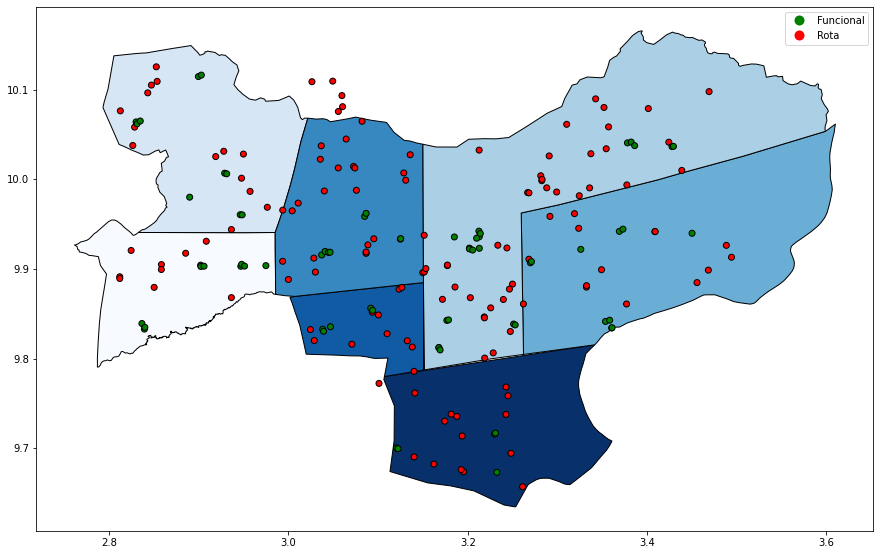

In [ ]:
# Plot the pumps 
district_geodf = gpd.GeoDataFrame(district_df, geometry="polygon")
pumps_aguapp_geodf = gpd.GeoDataFrame(pump_aguapp_df, geometry="point")

cmap = col.LinearSegmentedColormap.from_list("", ["green","red"])

#plt.rcParams["figure.figsize"] = (15,15)
base = district_geodf.plot(column="name",figsize=(15,15),cmap='Blues', edgecolor="black");
pumps_aguapp_geodf.plot(ax = base, column="status",legend=True,cmap=cmap,figsize=(15,15),edgecolor="black");

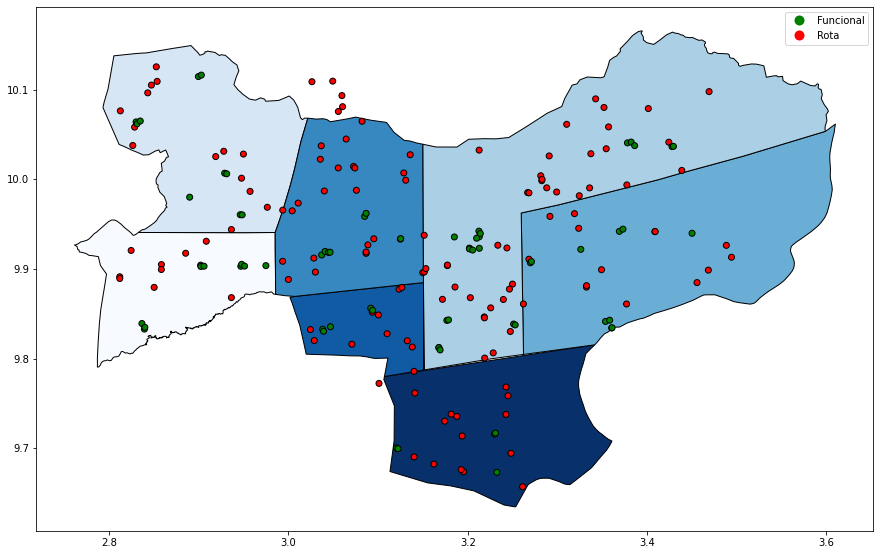

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(15,15))

base = district_geodf.plot(ax=ax, column="name",figsize=(15,15),cmap='Blues', edgecolor="black");
pumps_aguapp_geodf.plot(ax = base, column="status",legend=True,cmap=cmap,figsize=(15,15),edgecolor="black");

# Export the figure as a svg
fig.savefig('Pompes_Nikki.svg', format='svg', transparent=True,bbox_inches='tight' )

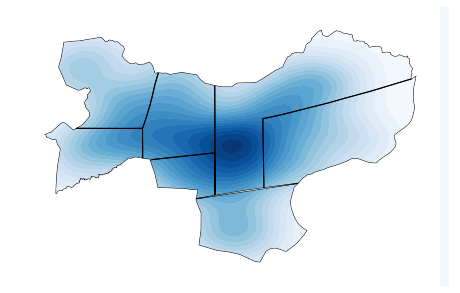

In [ ]:
# Heatmap de las bombas de aguapp
ax = gpt.kdeplot(pumps_aguapp_geodf, clip=district_geodf.geometry, shade=True, cmap='Blues', n_levels=20, shade_lowest=True);
gpt.polyplot(district_geodf, ax=ax, zorder=1);

### **Water Reservoir** Nikki

In [ ]:
# Get new data 
reservoir_query_A = overpassQueryBuilder(area=NIKKI_COM_ID, elementType=['relation','way','node'],selector='"natural"~"water"',out='body geom')

reservoir_res = overpass.query(reservoir_query_A,timeout=25)

reservoir_res_json = reservoir_res.toJSON()
reservoir_headers = ['id','type','area_id','tag','name','link','lat','lon','perim','area','boundary_lat','boundary_lon','polygon','point','district']
new_reservoir_data = []

# loop throught the elements in the response
for ele in reservoir_res_json['elements']:
    if
    geo_df = pd.DataFrame.from_records(ele['geometry'])
    poly = Polygon(zip(geo_df['lon'], geo_df['lat']))
    point = Point(poly.centroid.x,poly.centroid.y)
    boudary_lat =  str(geo_df['lat'].tolist())
    boudary_lon =  str(geo_df['lon'].tolist())
    ele_row = [
               ele.get('id',0),                    # id 
               ele.get('type'),                    # type
               0,                                  # area_id 
               ele['tags'].get('water',''),        # tag  
               ele['tags'].get('name',''),         # name 
               'https://www.openstreetmap.org/edit?' + str(ele.get('type','')) + '=' + str(ele.get('id','')),    # link
               str(poly.centroid.y),               # lat
               str(poly.centroid.x),               # lon
               str(poly.length * DEG_to_KM),       # perim
               str(poly.area * DEG_to_KM2),        # area
               boudary_lat,                        # boudary_lat
               boudary_lon,                        # boudary_lon    
               poly,                               # polygon   
               point,                              # point
               ''                                  # district
               ]
    new_reservoir_data.append(ele_row)

new_reservoir_df = pd.DataFrame(new_reservoir_data,columns=reservoir_headers)
new_reservoir_df.shape

[overpass] downloading data: [timeout:25][out:json];area(3602859963)->.searchArea;(relation["natural"~"water"](area.searchArea);way["natural"~"water"](area.searchArea);node["natural"~"water"](area.searchArea);); out body geom;


(42, 15)

In [ ]:
# Load Water Reservoir
reservoir_df = loadWaterReservoir()
reservoir_df.shape

# 40 - 1 Nov 2020
# 42 - 1 Ene 2021

(41, 15)

In [ ]:
# Update missing values in dataframe from spreadsheet
if new_reservoir_df is not None:
  for index, new_row in new_reservoir_df.iterrows():
    if not isIdalready(reservoir_df,new_row['id']) :
      reservoir_df = reservoir_df.append(new_row)

# Detelet all posible NaN
reservoir_df.fillna('')

# Update missing areas id
getAreaIdOfDataframe(reservoir_df)

# Update county origin
getDistrictOfVillage(district_df, reservoir_df)

reservoir_df.shape

(42, 15)

In [ ]:
# Save Water Reservoir
saveWaterReservoirBQ(reservoir_df)

1it [00:04,  4.71s/it]


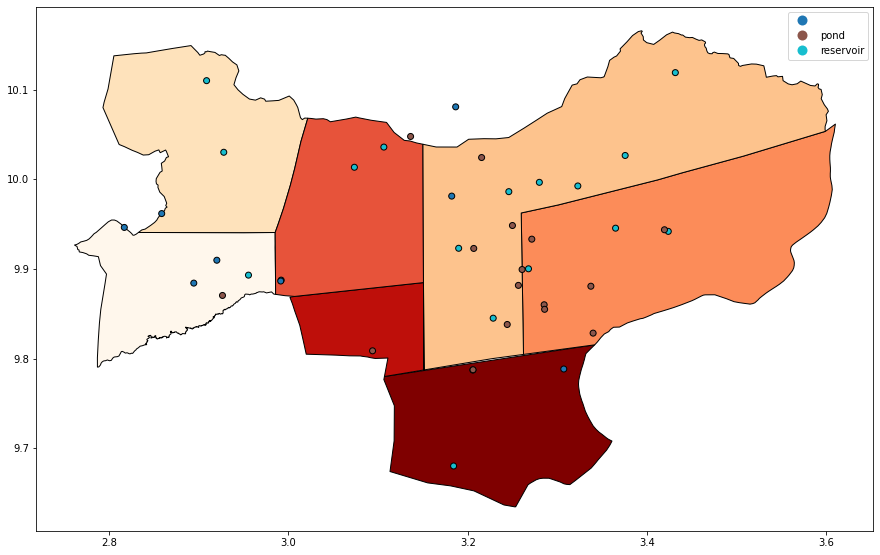

In [ ]:
# Plot the WaterReservoir 
district_geodf = gpd.GeoDataFrame(district_df, geometry="polygon")
reservoir_geodf = gpd.GeoDataFrame(reservoir_df, geometry="point")

#plt.rcParams["figure.figsize"] = (15,15)
base = district_geodf.plot(column="name", legend=True,figsize=(15,15),cmap='OrRd', edgecolor="black");
reservoir_geodf.plot(ax = base, column="tag",figsize=(15,15),edgecolor="black",legend=True);

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)


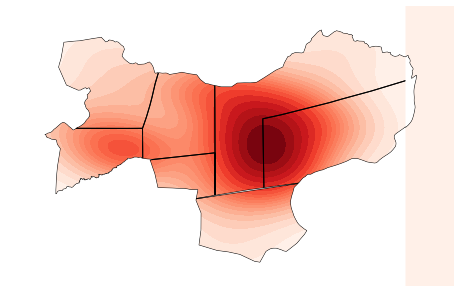

In [ ]:
# Heatmap de las bombas
ax = gpt.kdeplot(reservoir_geodf, clip=district_geodf.geometry, shade=True, cmap='Reds', n_levels=20, shade_lowest=True);
gpt.polyplot(district_geodf, ax=ax, zorder=1);

### **Water Reservoir** Spain




In [ ]:
reservoirSpain_headers = ['id','type','area_id','tag','name','project','link','lat','lon','perim','area','boundary_lat','boundary_lon','polygon','point','district']
new_reservoirSpain_data = []

# MURCIA
reservoirSpain_query_A = overpassQueryBuilder(area=MURCIA_ID, elementType=['way','node'],selector='"water"~"reservoir"',out='body geom')
reservoirSpain_query_B = overpassQueryBuilder(area=MURCIA_ID, elementType=['way','node'],selector='"landuse"~"basin"',out='body geom')

queries = [reservoirSpain_query_A,reservoirSpain_query_B]

for query in queries:
  reservoirSpain_res = overpass.query(query,timeout=25)
  reservoirSpain_res_json = reservoirSpain_res.toJSON()

  # loop throught the elements in the response A & B
  for ele in reservoirSpain_res_json['elements']:
    if 'geometry' in ele:
      geo_df = pd.DataFrame.from_records(ele['geometry'])
      poly = Polygon(zip(geo_df['lon'], geo_df['lat']))
      point = Point(poly.centroid.x,poly.centroid.y)
      boudary_lat =  str(geo_df['lat'].tolist())
      boudary_lon =  str(geo_df['lon'].tolist())
      ele_row = [
                 ele.get('id',0),                    # id 
                 ele.get('type'),                    # type
                 0,                                  # area_id 
                 ele['tags'].get('water',''),        # tag  
                 ele['tags'].get('name',''),         # name 
                 'Murcia',                           # project 
                 'https://www.openstreetmap.org/edit?' + str(ele.get('type','')) + '=' + str(ele.get('id','')),    # link
                 str(poly.centroid.y),               # lat
                 str(poly.centroid.x),               # lon
                 str(poly.length * DEG_to_KM),       # perim
                 str(poly.area * DEG_to_KM2),        # area
                 boudary_lat,                        # boudary_lat
                 boudary_lon,                        # boudary_lon    
                 poly,                               # polygon   
                 point,                              # point
                 ''                                  # district
                 ]
      new_reservoirSpain_data.append(ele_row)
  
murcia = len(new_reservoirSpain_data)
print('Embalses en MURCIA ' + str(murcia))

# CASTILLA
reservoirSpain_query_C = overpassQueryBuilder(area=CASTILLA_ID, elementType=['way','node'],selector='"water"~"reservoir"',out='body geom')
reservoirSpain_query_D = overpassQueryBuilder(area=CASTILLA_ID, elementType=['way','node'],selector='"landuse"~"basin"',out='body geom')

queries = [reservoirSpain_query_C,reservoirSpain_query_D]
for query in queries:
  reservoirSpain_res = overpass.query(query,timeout=25)
  reservoirSpain_res_json = reservoirSpain_res.toJSON()
  # loop throught the elements in the response C & D
  for ele in reservoirSpain_res_json['elements']:
    if 'geometry' in ele:
      geo_df = pd.DataFrame.from_records(ele['geometry'])
      poly = Polygon(zip(geo_df['lon'], geo_df['lat']))
      point = Point(poly.centroid.x,poly.centroid.y)
      boudary_lat =  str(geo_df['lat'].tolist())
      boudary_lon =  str(geo_df['lon'].tolist())
      ele_row = [
                 ele.get('id',0),                    # id 
                 ele.get('type'),                    # type
                 0,                                  # area_id 
                 ele['tags'].get('water',''),        # tag  
                 ele['tags'].get('name',''),         # name 
                 'Castilla',                         # project 
                 'https://www.openstreetmap.org/edit?' + str(ele.get('type','')) + '=' + str(ele.get('id','')),    # link
                 str(poly.centroid.y),               # lat
                 str(poly.centroid.x),               # lon
                 str(poly.length * DEG_to_KM),       # perim
                 str(poly.area * DEG_to_KM2),        # area
                 boudary_lat,                        # boudary_lat
                 boudary_lon,                        # boudary_lon    
                 poly,                               # polygon   
                 point,                              # point
                 ''                                  # district
                 ]
      new_reservoirSpain_data.append(ele_row)

total = len(new_reservoirSpain_data)
print('Embalses en CASTILLA ' + str(total - murcia))

new_reservoir_df = pd.DataFrame(new_reservoirSpain_data,columns=reservoirSpain_headers)
new_reservoir_df.shape

Embalses en MURCIA 2498
Embalses en CASTILLA 451


(2949, 16)

In [ ]:
# Load Water Reservoir
reservoirSpain_df = loadSpainWaterReservoir()
reservoirSpain_df.shape

# 434 - 11 May 2021

In [ ]:
# Save Water Reservoir
saveSpainWaterReservoirBQ(new_reservoir_df)

1it [00:03,  3.73s/it]


### OLD HELP

In [ ]:
# Plot Districts
district_df = loadDistricts();

plt.rcParams["figure.figsize"] = (10,10)
district_headers = ['id','area_id','type','name','link','nb_villages','population','density','lat','lon','perim','area','boundary_lat','boundary_lon','polygon']
new_district_data = []

# 0
x,y = district_df.loc[0,'polygon'].exterior.xy
new_x = x[:60]
new_y = y[:60]

new_boundary_lat = str(new_y.tolist())
new_boundary_lon = str(new_x.tolist())
new_poly = Polygon(zip(new_y,new_x))

new_district_data.append([
               district_df.loc[0,'id'],            # id 
               district_df.loc[0,'area_id'],       # area_id 
               district_df.loc[0,'type'],          # type  
               district_df.loc[0,'name'],          # name 
               district_df.loc[0,'link'],          # link
               district_df.loc[0,'nb_villages'],   # nb_villages
               district_df.loc[0,'population'],    # population
               district_df.loc[0,'density'],       # density
               new_poly.centroid.y,                # lat
               new_poly.centroid.x,                # lon
               new_poly.length,                    # perim
               new_poly.area,                      # area
               new_boundary_lat,                   # boudary_lat
               new_boundary_lon,                   # boudary_lon    
               new_poly,                           # polygon    
 ])

x,y = district_df.loc[1,'polygon'].exterior.xy
new_x = x[:788] + x[788:806][::-1]  + x[806:]
new_y = y[:788] + y[788:806][::-1]  + y[806:]

new_boundary_lat = str(new_y.tolist())
new_boundary_lon = str(new_x.tolist())
new_poly = Polygon(zip(new_y,new_x))

new_district_data.append([
               district_df.loc[1,'id'],            # id 
               district_df.loc[1,'area_id'],       # area_id 
               district_df.loc[1,'type'],          # type  
               district_df.loc[1,'name'],          # name 
               district_df.loc[1,'link'],          # link
               district_df.loc[1,'nb_villages'],   # nb_villages
               district_df.loc[1,'population'],    # population
               district_df.loc[1,'density'],       # density
               new_poly.centroid.y,                # lat
               new_poly.centroid.x,                # lon
               new_poly.length,                    # perim
               new_poly.area,                      # area
               new_boundary_lat,                   # boudary_lat
               new_boundary_lon,                   # boudary_lon    
               new_poly,                           # polygon    
 ])

# 2
x,y = district_df.loc[2,'polygon'].exterior.xy
new_x = x[:34] + x[34:97][::-1]
new_y = y[:34] + y[34:97][::-1]

new_boundary_lat = str(new_y.tolist())
new_boundary_lon = str(new_x.tolist())
new_poly = Polygon(zip(new_y,new_x))

new_district_data.append([
               district_df.loc[2,'id'],            # id 
               district_df.loc[2,'area_id'],       # area_id 
               district_df.loc[2,'type'],          # type  
               district_df.loc[2,'name'],          # name 
               district_df.loc[2,'link'],          # link
               district_df.loc[2,'nb_villages'],   # nb_villages
               district_df.loc[2,'population'],    # population
               district_df.loc[2,'density'],       # density
               new_poly.centroid.y,                # lat
               new_poly.centroid.x,                # lon
               new_poly.length,                    # perim
               new_poly.area,                      # area
               new_boundary_lat,                   # boudary_lat
               new_boundary_lon,                   # boudary_lon    
               new_poly,                           # polygon    
 ])

# 4
x,y = district_df.loc[3,'polygon'].exterior.xy

new_x = x
new_y = y

new_boundary_lat = str(new_y.tolist())
new_boundary_lon = str(new_x.tolist())
new_poly = Polygon(zip(new_y,new_x))

new_district_data.append([
               district_df.loc[3,'id'],            # id 
               district_df.loc[3,'area_id'],       # area_id 
               district_df.loc[3,'type'],          # type  
               district_df.loc[3,'name'],          # name 
               district_df.loc[3,'link'],          # link
               district_df.loc[3,'nb_villages'],   # nb_villages
               district_df.loc[3,'population'],    # population
               district_df.loc[3,'density'],       # density
               new_poly.centroid.y,                # lat
               new_poly.centroid.x,                # lon
               new_poly.length,                    # perim
               new_poly.area,                      # area
               new_boundary_lat,                   # boudary_lat
               new_boundary_lon,                   # boudary_lon    
               new_poly,                           # polygon    
 ])

# 5
x,y = district_df.loc[4,'polygon'].exterior.xy
new_y = y[:7] + y[7:15][::-1] + y[15:24][::-1] + y[24:25]+ y[27:29][::-1]+ y[30:35]
new_x = x[:7] + x[7:15][::-1] + x[15:24][::-1] + x[24:25]+ x[27:29][::-1]+ x[30:35]

new_boundary_lat = str(new_y.tolist())
new_boundary_lon = str(new_x.tolist())
new_poly = Polygon(zip(new_y,new_x))

new_district_data.append([
               district_df.loc[4,'id'],            # id 
               district_df.loc[4,'area_id'],       # area_id 
               district_df.loc[4,'type'],          # type  
               district_df.loc[4,'name'],          # name 
               district_df.loc[4,'link'],          # link
               district_df.loc[4,'nb_villages'],   # nb_villages
               district_df.loc[4,'population'],    # population
               district_df.loc[4,'density'],       # density
               new_poly.centroid.y,                # lat
               new_poly.centroid.x,                # lon
               new_poly.length,                    # perim
               new_poly.area,                      # area
               new_boundary_lat,                   # boudary_lat
               new_boundary_lon,                   # boudary_lon    
               new_poly,                           # polygon    
 ])


# 6
x,y = district_df.loc[5,'polygon'].exterior.xy
new_y = y[:1] + y[2:4][::-1] + y[4:10][::-1] + y[13:]
new_x = x[:1] + x[2:4][::-1] + x[4:10][::-1] + x[13:]

new_boundary_lat = str(new_y.tolist())
new_boundary_lon = str(new_x.tolist())
new_poly = Polygon(zip(new_y,new_x))

new_district_data.append([
               district_df.loc[5,'id'],            # id 
               district_df.loc[5,'area_id'],       # area_id 
               district_df.loc[5,'type'],          # type  
               district_df.loc[5,'name'],          # name 
               district_df.loc[5,'link'],          # link
               district_df.loc[5,'nb_villages'],   # nb_villages
               district_df.loc[5,'population'],    # population
               district_df.loc[5,'density'],       # density
               new_poly.centroid.y,                # lat
               new_poly.centroid.x,                # lon
               new_poly.length,                    # perim
               new_poly.area,                      # area
               new_boundary_lat,                   # boudary_lat
               new_boundary_lon,                   # boudary_lon    
               new_poly,                           # polygon    
 ])


# 7
x,y = district_df.loc[6,'polygon'].exterior.xy
new_y = y[:87][::-1] + y[87:103] + y[103:121][::-1]
new_x = x[:87][::-1] + x[87:103] + x[103:121][::-1]

new_boundary_lat = str(new_y.tolist())
new_boundary_lon = str(new_x.tolist())
new_poly = Polygon(zip(new_y,new_x))

new_district_data.append([
               district_df.loc[6,'id'],            # id 
               district_df.loc[6,'area_id'],       # area_id 
               district_df.loc[6,'type'],          # type  
               district_df.loc[6,'name'],          # name 
               district_df.loc[6,'link'],          # link
               district_df.loc[6,'nb_villages'],   # nb_villages
               district_df.loc[6,'population'],    # population
               district_df.loc[6,'density'],       # density
               new_poly.centroid.y,                # lat
               new_poly.centroid.x,                # lon
               new_poly.length,                    # perim
               new_poly.area,                      # area
               new_boundary_lat,                   # boudary_lat
               new_boundary_lon,                   # boudary_lon    
               new_poly,                           # polygon    
 ])

new_district_df = pd.DataFrame(new_district_data,columns=district_headers)